In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

import seaborn as sns

import scipy
from scipy.optimize import minimize
from scipy.stats import beta, cauchy
from plotly import express as px

# Show graphics in plotly locally
import plotly.io as pio
pio.renderers.default = 'iframe'

In [2]:
state_space = ("sunny", "cloudy", "rainy")

In [3]:
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

In [4]:
n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

In [5]:
def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)

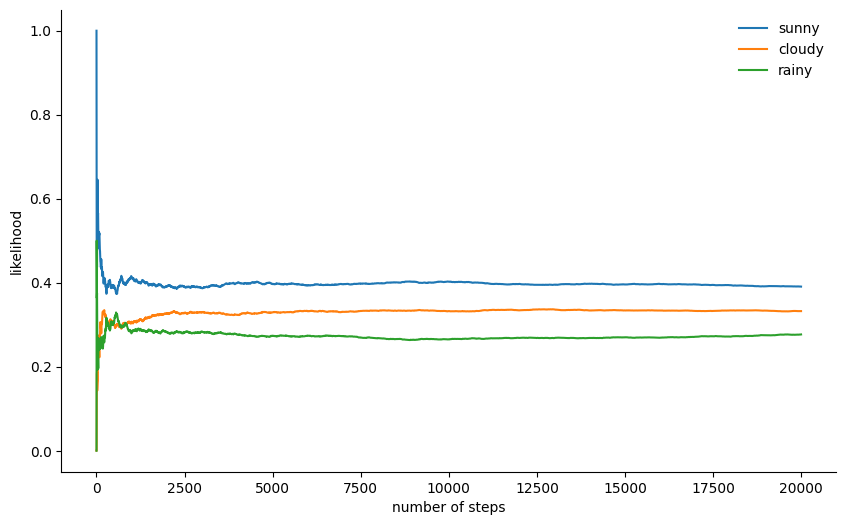

In [6]:
fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset 
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("likelihood")
ax.legend(frameon=False)
despine(ax, ('top', 'right'))
plt.savefig('Stac.jpg')

In [7]:
# Стационарное состояние MC

# Составляем систему уравнений
A = np.transpose(transition_matrix) - np.eye(3)
A[2, :] = [1, 1, 1]  # Учитываем уравнение суммы вероятностей
b = np.array([0, 0, 1])

# Решаем систему уравнений
pi = np.linalg.solve(A, b)

print("Стационарное состояние (вероятности):", np.round(pi, 4))

Стационарное состояние (вероятности): [0.3889 0.3333 0.2778]


## Rejection sampling

In [8]:
def p_params(a=1, b=1):
    distr = beta(a, b)
    return distr

In [9]:
prior_a = 10
prior_b = 10
p_h_values_range = np.arange(1e-10, 1, 0.01)
prior_distr_1 = p_params(10, 10)
prior_distr_2 = p_params(2, 10)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_h)$': prior_distr_1.pdf(p_h_values_range) + prior_distr_2.pdf(p_h_values_range),
})
fig = px.line(plot_df, x='$p_h$', y='$p(p_h)$', title=f'Prior pdf with parameters a={prior_a}, b={prior_b}')
fig

In [10]:
prior_a = 10
prior_b = 10
p_h_values_range = np.arange(1e-10, 1, 0.01)
prior_distr_1 = p_params(10, 10)
prior_distr_2 = p_params(2, 10)

plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_{h_1})$': prior_distr_1.pdf(p_h_values_range),
    '$p(p_{h_2})$': prior_distr_2.pdf(p_h_values_range),
    '$p(p_{h_{sum}})$': prior_distr_1.pdf(p_h_values_range) + prior_distr_2.pdf(p_h_values_range),
    '$p(p_{cauchy})$': cauchy.pdf(p_h_values_range-0.1)*15
})

fig = px.line(plot_df, x='$p_h$', y=['$p(p_{h_{sum}})$', '$p(p_{cauchy})$'])
fig

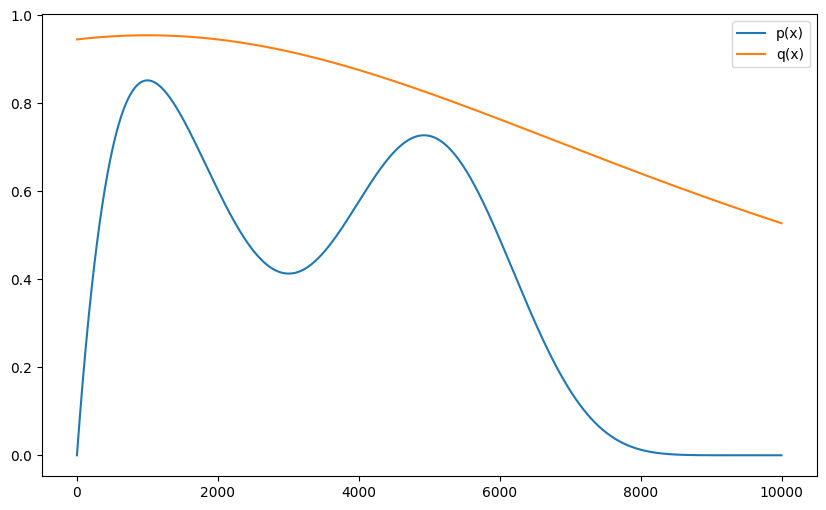

In [27]:
p_h_values_range = np.arange(0, 10000)
prior_distr_1 = p_params(10, 10)
prior_distr_2 = p_params(2, 10)
coeff = 1e-4



plot_df = pd.DataFrame({
    '$p_h$': p_h_values_range,
    '$p(p_{h_1})$': prior_distr_1.pdf(p_h_values_range*coeff),
    '$p(p_{h_2})$': prior_distr_2.pdf(p_h_values_range*coeff),
    '$p(p_{h_{sum}})$': (prior_distr_1.pdf(p_h_values_range*coeff) + prior_distr_2.pdf(p_h_values_range*coeff))/5,
    '$p(p_{cauchy})$': cauchy.pdf(p_h_values_range*coeff-0.1)*3
})

plt.plot(plot_df['$p_h$'], plot_df['$p(p_{h_{sum}})$'], label='p(x)')
plt.plot(plot_df['$p_h$'], plot_df['$p(p_{cauchy})$'], label='q(x)')
plt.legend()
plt.savefig('rej_sampl.jpg')
plt.show();


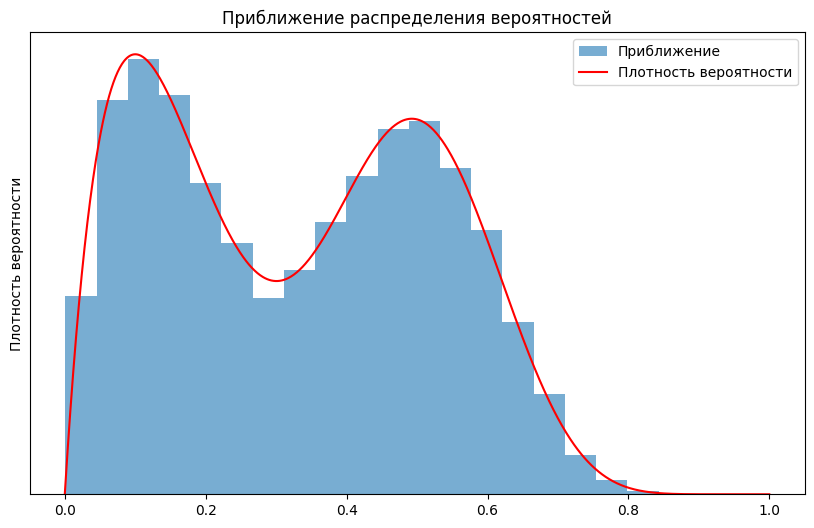

In [119]:
# Параметры бета-распределения
a = 10
b = 10

# Создание массива значений от 0 до 1
x = np.linspace(0, 1, 1000)

# Вычисление значений функции плотности бета-распределения
pdf = beta.pdf(x, 10, 10) + beta.pdf(x, 2, 10)

# Вычисление нормировочного множителя
norm_factor = np.trapz(pdf, x)

# Нормировка функции плотности
pdf_normalized = pdf/norm_factor

# Создание гистограммы сгенерированных значений бета-распределения
# Можно нарисовать гистограмму сгенерированных значений, если это требуется
# По умолчанию, чтобы показать функцию плотности и гистограмму, укажем alpha=0.6 для прозрачности 
h = np.concatenate((beta.rvs(10, 10, size=10000), beta.rvs(2, 10, size=10000)))
plt.hist(h, bins=20, density=1, alpha=0.6, label='Приближение')


# Построение графика нормированной функции плотности бета-распределения
plt.plot(x, pdf_normalized, 'r', label='Плотность вероятности')

# Добавление легенды и подписей осей
plt.legend()
# plt.xlabel('Значения')
plt.ylabel('Плотность вероятности')
plt.title('Приближение распределения вероятностей')
# plt.grid(True)
plt.yticks([])

# plt.savefig('approx_distr.jpg')
# Отображение графика
plt.show()